# Code Description
This code contains many functions for testing regularization methods across parameter sets and noise realizations

Functions use a standard indexing to refer to our 4 parameters: 0 index is c1, 1 is c2, 2 is T21, and 3 is T22
Regularization is applied through use of scipy.optimize.curve_fit in the estimate_parameters function

Application of NLLS and regularization across parameters and noise realization can be seen below

Deep neural network (DNN) regularization models are generated using the Neural Network Regularization file

In general, you will be adjusting SNR below and changing the parameter sets under "Use prior distributions of c1, c2, T21, and T22, then evaluating how effective our different estimation methods are

Numerical method to calculate biased CRLB is currently under progress, so work with Dr. Balan to get that sorted

This code was primarily written by Ryan Neff (RN) and then furthur developed by Griffin Hampton (GSH)

This is the code that is intended to be used during the manuscript that RN is writing

# Import Packages

In [32]:
#%matplotlib widget
import h5py
import scipy
import scipy.io
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import statistics
import math
import time
import itertools
from tqdm import trange
from keras.models import load_model
from datetime import date
import pickle

# Options

In [33]:
oracle_opt = False
minMSE_opt = False
GCV_opt = True
load_fig2 = False

figure1_opt = False

# Define Parameters

In [34]:
SNR = 100
n_elements = 128
c1 = 0.5
c2 = 1 - c1
T21 = 50
T22 = 100
#Weighting term to ensure the c_i and T2_i are roughly the same magnitude
ob_weight = 100
Nth = 5
n_noise_realizations = 500 #500

num_multistarts = 10

upper_bound = [2,2,500,1500] #Set upper bound on parameters c1, c2, T21, T22, respectively
initial = (0.5, 0.5, 250, 750) #Set initial guesses

tdata = np.linspace(0, 635, n_elements)
lambdas = np.append(0, np.logspace(-7,3,51))

explore_corners = False

###################### Parameters Loop Through
c1_set = [0.5]#[0.0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0]
c2_set = 1-np.array(c1_set)
T21_set = [10,50]#[10,20,30,40,50]
T22_set = [70,150]#[70,90,110,130,150]

##################### Important for Naming
date = date.today()
day = date.strftime('%d')
month = date.strftime('%B')[0:3]
year = date.strftime('%y')

##################### Stored Dictionary
runInfo = {
    "SNR": SNR,
    "c1": c1_set,
    "c2": c2_set,
    "T21": T21_set,
    "T22": T22_set,
    'lambdas': lambdas,
    'times': tdata,
    'noise_realizations': n_noise_realizations
}

# Define General Functions

In [35]:
########################### Simple Functions ##############################
# Two parameter definition of s(t) with regularization parameter lambda
def G(t, con_1, con_2, tau_1, tau_2): 
    function = con_1*np.exp(-t/tau_1) + con_2*np.exp(-t/tau_2)
    return function

def G_tilde(lam, SA = 1):
    #SA defines the signal amplitude, defaults to 1 for simulated data
    def Gt_lam(t, con1, con2, tau1, tau2):
        return np.append(G(t, con1, con2, tau1, tau2), [lam*con1/SA, lam*con2/SA, lam*tau1/ob_weight, lam*tau2/ob_weight])
    return Gt_lam

def G_tilde_linear(T21, T22, lam):
    def G_linear(t, c1, c2):
        return np.append(G(t, c1, c2, T21, T22), [lam*c1, lam*c2])
    return G_linear

def add_noise(signal, SNR):
    #Given a noiseless signal, adds noise at given SNR and returns a noisy signal
    signal_length = len(signal)
    noise_sd = signal[0]/SNR
    noisy_signal = signal + np.random.normal(0, noise_sd, signal_length)
    return noisy_signal

########################### Parameter Estimation Functions ########################

def estimate_parameters(data, lam, n_initials = num_multistarts, post_normalize = True):
    #Pick n_initials random initial conditions within the bound, and choose the one giving the lowest model-data mismatch residual
    random_residuals = []
    estimates = np.zeros((4,n_initials))
    for i in range(n_initials):
        ic1 = np.random.uniform(0,1)
        ic2 = 1-ic1
        iT21 = np.random.uniform(0,upper_bound[2])
        iT22 = np.random.uniform(0,upper_bound[3])
        p0 = [ic1,ic2,iT21,iT22]
        
        data_tilde = np.append(data, [0,0,0,0])  
    
        (c1e, c2e, T21e, T22e), cov = curve_fit(G_tilde(lam), tdata, data_tilde, bounds = (0, upper_bound), p0=p0, max_nfev = 4000)
        
        #Require T22>T21
        if T22e > T21e:
            estimates[:,i] = [c1e, c2e, T21e, T22e]
            estimated_model = G(tdata, c1e, c2e, T21e, T22e)
        else:
            estimates[:,i] = [c2e, c1e, T22e, T21e]
            estimated_model = G(tdata, c2e, c1e, T22e, T21e)
        
        residual = np.sum((estimated_model - data)**2)
        random_residuals.append(residual)
    min_residual_idx = np.argmin(random_residuals)
    min_residual_estimates = estimates[:,min_residual_idx]

    if post_normalize:
        ci_sum = min_residual_estimates[0] + min_residual_estimates[1]
        min_residual_estimates[0] = min_residual_estimates[0]/ci_sum
        min_residual_estimates[1] = min_residual_estimates[1]/ci_sum

        
    return min_residual_estimates


### Unused as of 11/2/22
def min_bias_estimates(c1, c2, T21, T22, n=100, lambdas = np.logspace(-7,3, 51), aggregate=True, agg_arr = [1,1,0.01,0.01]):
    #Returns aggregate bias, variance, and MSE of the estimates generated 
    #from using the lambda which minimizes bias for each noise realization
    agg_arr = np.array(agg_arr)
    noiseless_curve = G(tdata, c1, c2, T21, T22)
    
    bias = np.zeros(4)
    variance = np.zeros(4)
    MSE = np.zeros(4)
    
    min_bias_lambdas = []
    min_bias_est = []
    for i in range(n):
        np.random.seed(i)
        data = add_noise(noiseless_curve, SNR)
        agg_bias_list = []
        temp_estimates = []
        for l in range(len(lambdas)):
            lam = lambdas[l]
            est = estimate_parameters(data, lam)
            temp_estimates.append(est)
            agg_bias_list.append(np.absolute(est-[c1,c2,T21,T22]).dot(agg_arr)) #L1 error
        
        min_bias_idx = np.argmin(agg_bias_list)
        
        min_bias_lambdas.append(lambdas[min_bias_idx])
        min_bias_est.append(temp_estimates[min_bias_idx])
    
    min_bias_est = np.array(min_bias_est)
    
    c1est = min_bias_est[:,0]
    c2est = min_bias_est[:,1]
    T21est = min_bias_est[:,2]
    T22est = min_bias_est[:,3]
    
    bias[0] = (c1est - [c1]*n).sum()/n #GSH - check this - why are we multiplying by n - does this do something to the size - what about broadcasting?
    bias[1] = (c2est - [c2]*n).sum()/n
    bias[2] = (T21est - [T21]*n).sum()/n
    bias[3] = (T22est - [T22]*n).sum()/n
    
    variance[0] = np.var(c1est)
    variance[1] = np.var(c2est)
    variance[2] = np.var(T21est)
    variance[3] = np.var(T22est)
    
    MSE = bias**2 + variance
    
    agg_bias = np.absolute(bias).dot(agg_arr)
    agg_variance = variance.dot(agg_arr**2)
    agg_MSE = MSE.dot(agg_arr**2)
    
    if aggregate==True:
        return agg_bias, agg_variance, agg_MSE, min_bias_lambdas
    else:
        return bias, variance, MSE, min_bias_lambdas

def J(t, con1, con2, tau1, tau2):
    func1 = np.exp(-t/tau1)
    func2 = np.exp(-t/tau2)
    func3 = (con1*t)*np.exp(-t/tau1)/(tau1**2)
    func4 = (con2*t)*np.exp(-t/tau2)/(tau2**2)
    jacobian = np.stack((func1, func2, func3, func4), axis=-1)
    
    return jacobian

def cov_matrix(con1, con2, tau1, tau2, SNR):
    noise_sd = 1/SNR
    jacobians = J(tdata, con1, con2, tau1, tau2).transpose()@J(tdata, con1, con2, tau1, tau2) 
    covariance = np.linalg.inv(jacobians)
    return (noise_sd**2)*covariance

def get_min_MSE_array(c1_set, c2_set, T21_set, T22_set, lambdas, nReps = n_noise_realizations, verbose=False):
    #Given a prior set of true parameters and a parameter of interest, 
    #find lambdas which give lowest MSE for each combination of parameters
    n_c1 = len(c1_set)
    n_c2 = len(c2_set)
    n_T21 = len(T21_set)
    n_T22 = len(T22_set)
    n_params = n_c1*n_c2*n_T21*n_T22
    n_lambdas = len(lambdas)
    
    min_MSE_array = np.zeros((n_c1,n_c2,n_T21,n_T22,4))
    unreg_MSE_array = np.zeros((n_c1,n_c2,n_T21,n_T22,4))
    improvement_array = np.zeros((n_c1,n_c2,n_T21,n_T22,4))
    min_lambda_array = np.zeros((n_c1,n_c2,n_T21,n_T22,4))
    iterator = 1
    start_time = time.time()
    for ic1 in range(n_c1):
        c1 = c1_set[ic1]
        for ic2 in range(n_c2):
            c2 = c2_set[ic2]
            for iT21 in range(n_T21):
                T21 = T21_set[iT21]
                for iT22 in range(n_T22):
                    T22 = T22_set[iT22]
                    if verbose:
                        print(f'Calculating combo {iterator} of {n_params}: {np.round(iterator/n_params*100,2)}%: ' +  
                                f'Projected time left {(time.time()-start_time)/iterator*(n_params-iterator)/60}min')
                        iterator+=1
                    p_true = [c1, c2, T21, T22]
                    noiseless_curve = G(tdata, c1, c2, T21, T22)
                    estimates = np.zeros((nReps,n_lambdas,4))
                    for i in trange(nReps):
                        for l in range(n_lambdas):
                            data = add_noise(noiseless_curve, SNR)
                            est = estimate_parameters(data, lam=lambdas[l])
                            estimates[i,l,:] = est
                    
                    bias = (estimates - p_true).sum(axis=0)/nReps
                    assert(np.allclose(np.mean(estimates - p_true, axis = 0),bias))
                    variance = np.var(estimates, axis=0)
                    MSE = variance + bias**2
                    
                    min_MSE = np.min(MSE, axis=0)
                    min_MSE_array[ic1,ic2,iT21,iT22,:] = min_MSE
                    
                    unreg_MSE = MSE[0,:]
                    unreg_MSE_array[ic1,ic2,iT21,iT22,:] = unreg_MSE
                    
                    improvement = (unreg_MSE - min_MSE)/unreg_MSE
                    improvement_array[ic1,ic2,iT21,iT22,:] = improvement
                    
                    min_MSE_lambda_indx = np.argmin(MSE,axis=0)
                    min_MSE_lambdas = lambdas[min_MSE_lambda_indx]
                    min_lambda_array[ic1,ic2,iT21,iT22,:] = min_MSE_lambdas
                    
    return min_MSE_array, min_lambda_array, improvement_array, unreg_MSE_array

def get_lam_selection_MSE_array(c1_set, c2_set, T21_set, T22_set, lambdas, lam_select, 
                                noise_iterations=n_noise_realizations, verbose=False, aggregate=False, safety_factor=2, model = None):
    #Lam_select is either 'oracle', 'DP', 'GCV', or 'DNN'
    #Defines which method is used to select lambda
    n_c1 = len(c1_set)
    n_c2 = len(c2_set)
    n_T21 = len(T21_set)
    n_T22 = len(T22_set)
    n_params = n_c1*n_c2*n_T21*n_T22
    n_lambdas = len(lambdas)
    
    MSE_array = np.zeros((n_c1,n_c2,n_T21,n_T22,4))
    imp_bias_array = np.zeros((n_c1,n_c2,n_T21,n_T22,4))
    imp_var_array = np.zeros((n_c1,n_c2,n_T21,n_T22,4))
    unreg_MSE_array = np.zeros((n_c1,n_c2,n_T21,n_T22,4))
    improvement_array = np.zeros((n_c1,n_c2,n_T21,n_T22,4))
    lambda_array = np.zeros((n_c1,n_c2,n_T21,n_T22,4))
    iterator = 1
    print("Starting lam selection with " + lam_select)
    start_time = time.time()
    for ic1 in range(n_c1):
        c1 = c1_set[ic1]
        c2 = 1 - c1
        for ic2 in range(1):
            for iT21 in range(n_T21):
                T21 = T21_set[iT21]
                for iT22 in range(n_T22):
                    T22 = T22_set[iT22]
                    if verbose:
                        print(f'{lam_select}: Calculating combo {iterator} of {n_params}: {np.round(iterator/n_params*100,2)}%: ' +  
                                f'Projected time left {(time.time()-start_time)/iterator*(n_params-iterator)/60}min')
                        iterator+=1
                    p_true = [c1, c2, T21, T22]
                    noiseless_curve = G(tdata, c1, c2, T21, T22)
                    estimates = np.zeros((noise_iterations,4))
                    estimates_unreg = np.zeros((noise_iterations,4))
                    for i in trange(noise_iterations):
                        data = add_noise(noiseless_curve, SNR)
                        if lam_select == 'oracle':
                            lam = oracle_lambda(c1, c2, T21, T22, data, lambdas, aggregate=aggregate)[1]
                        elif lam_select == 'DP':
                            lam = DP_lambda(data, safety_factor, lambdas)
                        elif lam_select == 'GCV':
                            try:
                                lam = GCV_lambda(data, lambdas)
                            except:
                                lam=0
                        elif lam_select == 'DNN':
                            lam = DNN_lambda(data, model)
                        lambda_array[ic1,ic2,iT21,iT22,:] = lam
                        est = estimate_parameters(data, lam)
                        est_unreg = estimate_parameters(data, 0)
                        estimates[i,:] = est
                        estimates_unreg[i,:] = est_unreg
                    
                    bias = (estimates - p_true).sum(axis=0)/noise_iterations
                    variance = np.var(estimates, axis=0)
                    MSE = variance + bias**2
                    MSE_array[ic1,ic2,iT21,iT22,:] = MSE
                    
                    unreg_bias = (estimates_unreg - p_true).sum(axis=0)/noise_iterations
                    unreg_variance = np.var(estimates_unreg, axis=0)
                    unreg_MSE = unreg_variance + unreg_bias**2
                    unreg_MSE_array[ic1,ic2,iT21,iT22,:] = unreg_MSE
                    
                    improvement = (unreg_MSE - MSE)/unreg_MSE
                    improvement_array[ic1,ic2,iT21,iT22,:] = improvement

                    imp_bias_array[ic1,ic2,iT21,iT22,:] = (unreg_bias - bias)/unreg_bias
                    imp_var_array[ic1,ic2,iT21,iT22,:] = (unreg_variance - variance)/unreg_variance
                    
    return MSE_array, lambda_array, improvement_array, imp_bias_array, imp_var_array

################## Lambda Selection Methods ########################

def DP_lambda(data, safety_factor, disclambdas, fSNR = SNR):
    #Returns a value of lambda given the data set, a safety factor, the SD of the noise, and a set of lambdas to iterate over
    discrepancy_lambda = 0
    noise_sd = data[0]/fSNR
    error_norm = len(tdata)*(noise_sd)**2
    residual_norm = []
    for lam in disclambdas:
        est = estimate_parameters(data,lam)

        residual_norm.append(((G(tdata, est[0], est[1], est[2], est[3])-data)**2).sum())
        
        for i in range(len(residual_norm)):
            if residual_norm[i] < safety_factor*error_norm:
                discrepancy_lambda = disclambdas[i]
            else:
                break
    return discrepancy_lambda

def oracle_lambda(c1, c2, T21, T22, data, lambdas, aggregate=False, wgt = np.array([1,1,1/ob_weight,1/ob_weight])):
    n_lambdas = len(lambdas)
    estimates = np.zeros((n_lambdas,4))
    p_true = [c1, c2, T21, T22]
    for l in range(n_lambdas):
        lam = lambdas[l]
        estimates[l,:] = estimate_parameters(data, lam)
    error = np.absolute(estimates - p_true)
    
    if aggregate == True:
        #If aggregating, returns the estimates which minimize the weighted sum of the error along with a single lambda
        agg_error = np.sum((error*wgt)**2, axis = 1) #error@wgt - L2 vs L1 error
        assert(np.size(agg_error) == np.size(lambdas))
        min_agg_idx = np.argmin(agg_error)
        min_agg_est = estimates[min_agg_idx,:]
        min_lambda = lambdas[min_agg_idx]
        return min_agg_est, min_lambda
    if aggregate == False:
        #If not aggregating, returns the estimates for each parameter which minimize their respective errors
        #Also returns 4 lambdas, one for each of the 4 parameters
        min_idx_array = np.argmin(error,axis=0)
        min_est_array = estimates[min_idx_array,:]
        min_lambdas_array = lambdas[min_idx_array]
        return min_est_array, min_lambdas_array

def get_GCV(GCV_data, GCV_lam):
    GCVd_tilde = np.append(GCV_data, [0,0,0,0])

    (rc1e, rc2e, rT21e, rT22e), rcov = curve_fit(G_tilde(GCV_lam), tdata, GCVd_tilde, bounds = (0, upper_bound), p0=initial, max_nfev = 4000)
    
    #Require that T22>T21
    if rT22e > rT21e:
        c1GCV = rc1e
        c2GCV = rc2e
        T21GCV = rT21e
        T22GCV = rT22e
    else:
        c1GCV = rc2e
        c2GCV = rc1e
        T21GCV = rT22e
        T22GCV = rT21e
    wmat = np.array([[1,0,0,0],[0,1,0,0],[0,0,0.01,0],[0,0,0,0.01]])
    
    GCVjacobian = J(tdata, c1GCV, c2GCV, T21GCV, T22GCV)
    GCV_residual = ((G(tdata, c1GCV, c2GCV, T21GCV, T22GCV)-GCV_data)**2).sum()
    C_GCV = GCVjacobian@np.linalg.inv(GCVjacobian.transpose()@GCVjacobian+(GCV_lam**2)*wmat.transpose()@wmat)@GCVjacobian.transpose()
    (n,n) = C_GCV.shape
    identity = np.identity(n)

    GCVdenominator = (identity - C_GCV).trace()

    GCV = GCV_residual/(GCVdenominator**2)
    return GCV

def GCV_lambda(GCV_data, GCVlambdas, give_curve=False):
    #Given a data set and a set of lambdas to iterate through, gives the lambda which minimizes the GCV equation
    GCV_values = []
    for GCVlam in GCVlambdas:
        GCV_values.append(get_GCV(GCV_data, GCVlam))
    min_GCV_lam = GCVlambdas[np.argmin(GCV_values)]
    if give_curve:
        return min_GCV_lam, GCV_values
    else:
        return min_GCV_lam

def DNN_lambda(data, model):
    data_dim = np.reshape(data, (1, len(data)))
    DNN_lam = 10**(model(data_dim))
    return DNN_lam

# Define Weighted Regularization Functions - Generating MSE vs. Lambda Curves

In [36]:
def weighted_regularization(n_params, param_values, param_distr, lambdas, datasets):
    n_c1 = n_params[0]
    n_c2 = n_params[1]
    n_T21 = n_params[2]
    n_T22 = n_params[3]
    
    c1_values = param_values[0]
    c2_values = param_values[1]
    T21_values = param_values[2]
    T22_values = param_values[3]
    
    c1_distribution = param_distr[0]
    c2_distribution = param_distr[1]
    T21_distribution = param_distr[2]
    T22_distribution = param_distr[3]
    
    n_lambdas = len(lambdas)
    
    weighted_bias = 0
    weighted_variance = 0
    weighted_MSE = 0
    
    iterator = 1
    total_combos = n_c1 * n_c2 * n_T21 * n_T22
    for nc1 in range(n_c1):
        for nc2 in range(n_c2):
            for nt1 in range(n_T21):
                for nt2 in range(n_T22):
                    print(f'Calculating combo {iterator} of {total_combos}')
                
                    con1 = c1_values[nc1]
                    con2 = c2_values[nc2]
                    tau1 = T21_values[nt1]
                    tau2 = T22_values[nt2]
                    p_true = [con1, con2, tau1, tau2]
                    weight = c1_distribution[nc1]*c2_distribution[nc2]*T21_distribution[nt1]*T22_distribution[nt2]
                    
                    estimates = np.zeros((n_noise_realizations,n_lambdas,4))
                    for i in trange(n_noise_realizations):
                        data = datasets[nc1,nc2,nt1,nt2,i,:]
                        for l in range(n_lambdas):
                            lam = lambdas[l]
                            est = estimate_parameters(data, lam)
                            estimates[i,l] = est
                    
                    bias = (estimates - p_true).sum(axis=0)/n_noise_realizations
                    variance = np.var(estimates, axis=0)
                    MSE = variance + bias**2
                    
                    weighted_bias += weight*bias
                    weighted_variance += weight*variance
                    weighted_MSE += weight*MSE
    return weighted_bias, weighted_variance, weighted_MSE

def weighted_GCV_reg(n_params, param_values, param_distr, lambdas, datasets):
    n_c1 = n_params[0]
    n_c2 = n_params[1]
    n_T21 = n_params[2]
    n_T22 = n_params[3]
    
    c1_values = param_values[0]
    c2_values = param_values[1]
    T21_values = param_values[2]
    T22_values = param_values[3]
    
    c1_distribution = param_distr[0]
    c2_distribution = param_distr[1]
    T21_distribution = param_distr[2]
    T22_distribution = param_distr[3]
    
    n_lambdas = len(lambdas)
    
    weighted_bias = 0
    weighted_variance = 0
    weighted_MSE = 0
    
    GCV_lambda_list = []
    iterator = 1
    total_combos = n_c1 * n_c2 * n_T21 * n_T22
    for nc1 in range(n_c1):
        for nc2 in range(n_c2):
            for nt1 in range(n_T21):
                for nt2 in range(n_T22):
                    print(f'Calculating combo {iterator} of {total_combos}')
                
                    con1 = c1_values[nc1]
                    con2 = c2_values[nc2]
                    tau1 = T21_values[nt1]
                    tau2 = T22_values[nt2]
                    p_true = [con1, con2, tau1, tau2]
                    weight = c1_distribution[nc1]*c2_distribution[nc2]*T21_distribution[nt1]*T22_distribution[nt2]
                    
                    GCV_estimates = []
                    for i in trange(n_noise_realizations):
                        data = datasets[nc1,nc2,nt1,nt2,i,:]
                        lam = GCV_lambda(data, lambdas)
                        GCV_lambda_list.append(lam)
    
                        GCVEst = estimate_parameters(data, lam)
                        GCV_estimates.append(GCVEst)

                    GCV_estimates = np.array(GCV_estimates)
                    
                    GCV_bias = (GCV_estimates - p_true).sum(axis=0)/n_noise_realizations
                    GCV_variance = np.var(GCV_estimates, axis=0)
                    GCV_MSE = GCV_variance + GCV_bias**2
                    
                    weighted_bias += weight*GCV_bias
                    weighted_variance += weight*GCV_variance
                    weighted_MSE += weight*GCV_MSE
    return weighted_bias, weighted_variance, weighted_MSE, GCV_lambda_list

def weighted_DNN_reg(model, n_params, param_values, param_distr, datasets):
    #Tests the DNN over a range of true parameter values, returns the weighted bias, variance, and MSE of the DNN estimates
    n_c1 = n_params[0]
    n_c2 = n_params[1]
    n_T21 = n_params[2]
    n_T22 = n_params[3]
    
    c1_values = param_values[0]
    c2_values = param_values[1]
    T21_values = param_values[2]
    T22_values = param_values[3]
    
    c1_distribution = param_distr[0]
    c2_distribution = param_distr[1]
    T21_distribution = param_distr[2]
    T22_distribution = param_distr[3]
    
    weighted_bias = 0
    weighted_variance = 0
    weighted_MSE = 0
    
    total_DNN_lambdas = []

    iterator = 1
    total_combos = n_c1 * n_c2 * n_T21 * n_T22
    for nc1 in range(n_c1):
        for nc2 in range(n_c2):
            for nt1 in range(n_T21):
                for nt2 in range(n_T22):
                    print(f'Calculating combo {iterator} of {total_combos}')
                
                    con1 = c1_values[nc1]
                    con2 = c2_values[nc2]
                    tau1 = T21_values[nt1]
                    tau2 = T22_values[nt2]
                    p_true = [con1, con2, tau1, tau2]
                
                    weight = c1_distribution[nc1]*c2_distribution[nc2]*T21_distribution[nt1]*T22_distribution[nt2]
                    underlying = G(tdata, con1, con2, tau1, tau2)
                    param_datasets = datasets[nc1,nc2,nt1,nt2,:,:]
                    DNN_lambdas = np.array(model(param_datasets))
            
                    DNN_estimates = []
                    for i in range(n_noise_realizations):
                        data = param_datasets[i,:]
                        lam = 10**DNN_lambdas[i]
                        total_DNN_lambdas.append(lam)
    
                        DNNEst = estimate_parameters(data, lam)
                        DNN_estimates.append(DNNEst)

                    DNN_estimates = np.array(DNN_estimates)
                    
                    DNN_bias = (DNN_estimates - p_true).sum(axis=0)/n_noise_realizations
                    DNN_variance = np.var(DNN_estimates, axis=0)
                    DNN_MSE = DNN_variance + DNN_bias**2
                    
                    weighted_bias += weight*DNN_bias
                    weighted_variance += weight*DNN_variance
                    weighted_MSE += weight*DNN_MSE
    return weighted_bias, weighted_variance, weighted_MSE, total_DNN_lambdas

def weighted_oracle_reg(n_params, param_values, param_distr, lambdas, datasets):
    n_c1 = n_params[0]
    n_c2 = n_params[1]
    n_T21 = n_params[2]
    n_T22 = n_params[3]
    
    c1_values = param_values[0]
    c2_values = param_values[1]
    T21_values = param_values[2]
    T22_values = param_values[3]
    
    c1_distribution = param_distr[0]
    c2_distribution = param_distr[1]
    T21_distribution = param_distr[2]
    T22_distribution = param_distr[3]
    
    n_lambdas = len(lambdas)
    
    weighted_bias = 0
    weighted_variance = 0
    weighted_MSE = 0
    
    oracle_lambda_list = []
    iterator = 1
    total_combos = n_c1 * n_c2 * n_T21 * n_T22
    for nc1 in range(n_c1):
        for nc2 in range(n_c2):
            for nt1 in range(n_T21):
                for nt2 in range(n_T22):
                    print(f'Calculating combo {iterator} of {total_combos}')
                
                    con1 = c1_values[nc1]
                    con2 = c2_values[nc2]
                    tau1 = T21_values[nt1]
                    tau2 = T22_values[nt2]
                    p_true = [con1, con2, tau1, tau2]
                    weight = c1_distribution[nc1]*c2_distribution[nc2]*T21_distribution[nt1]*T22_distribution[nt2]
                    
                    oracle_estimates = []
                    for i in trange(n_noise_realizations):
                        data = datasets[nc1,nc2,nt1,nt2,i,:]
                        oraEst, lam = oracle_lambda(con1, con2, tau1, tau2, data, lambdas, aggregate=True)
                        oracle_lambda_list.append(lam)
                        oracle_estimates.append(np.array(oraEst))

                    oracle_estimates = np.array(oracle_estimates)
                    
                    ora_bias = (oracle_estimates - p_true).sum(axis=0)/n_noise_realizations
                    #Why not just use the mean?
                    ora_variance = np.var(oracle_estimates, axis=0)
                    ora_MSE = ora_variance + ora_bias**2
                    
                    weighted_bias += weight*ora_bias
                    weighted_variance += weight*ora_variance
                    weighted_MSE += weight*ora_MSE
    return weighted_bias, weighted_variance, weighted_MSE, oracle_lambda_list

# Generate Data Sets

In [37]:
datasets = np.zeros((n_noise_realizations, n_elements))
noiseless_curve = G(tdata, c1, c2, T21, T22)
for n in trange(n_noise_realizations):
    np.random.seed(n)
    data = add_noise(noiseless_curve, SNR)
    datasets[n,:] = data

100%|██████████| 500/500 [00:00<00:00, 38566.18it/s]


# Use prior distributions of c1, c2, T21, and T22

In [38]:
#General idea is to define sets of parameters and test regularization methods across those parameters, 
#then do a weighted average to see how performance is affected by choice of parameter set
#Weighting array to ensure parameters are roughly the same magnitude
wgt = np.array([1,1,0.01,0.01])
#Number of values in each parameter set, index 0 refers to c1, 1 to c2, 2 to T21, and 3 to T22
n_params = [1,1,1,1]
n_total_params = n_params[0]*n_params[1]*n_params[2]*n_params[3]

n_lambdas = 51 #Number of lambdas to loop through
lambdas = np.logspace(-7, 3, n_lambdas) #Set range of lambda values
#Defines sets for each parameter using np.linspace
c1_values = np.linspace(0.5,0.5, n_params[0])
c2_values = np.linspace(0.5,0.5, n_params[1])
T21_values = np.linspace(40, 40, n_params[2])
T22_values = np.linspace(130, 130, n_params[3])
#Parametrized version of above, done to save some space
param_values = [c1_values, c2_values, T21_values, T22_values]
#Define weighted distributions of the parameters, here just weights each value equally
c1_distribution = np.array([1]*n_params[0])
c1_distribution = c1_distribution/c1_distribution.sum()
c2_distribution = np.array([1]*n_params[1])
c2_distribution = c2_distribution/c2_distribution.sum()
T21_distribution = np.array([1]*n_params[2])
T21_distribution = T21_distribution/T21_distribution.sum()
T22_distribution = np.array([1]*n_params[3])
T22_distribution = T22_distribution/T22_distribution.sum()
#Parametrized distributions to save some space
param_distr = [c1_distribution, c2_distribution, T21_distribution, T22_distribution]

param_averages = [value@distr for value, distr in zip(param_values, param_distr)]

#Generate the data sets and calculate the weighted CRLB over the parameter distribution
#Pregenerating the data sets saves some computation time later
datasets_distr = np.zeros((n_params[0],n_params[1],n_params[2],n_params[3],n_noise_realizations,n_elements))
weighted_CRLB = 0
for nc1 in trange(n_params[0]):
    for nc2 in range(n_params[1]):
        for nt1 in range(n_params[2]):
            for nt2 in range(n_params[3]):
                
                con1 = c1_values[nc1]
                #con2 = c2_values[nc2]
                con2 = 1-con1
                tau1 = T21_values[nt1]
                tau2 = T22_values[nt2]
                
                cov = cov_matrix(con1, con2, tau1, tau2, SNR)
                weighted_CRLB += np.array([cov[0,0],cov[1,1],cov[2,2],cov[3,3]])/n_total_params  
                p_true = [con1, con2, tau1, tau2]
                
                underlying = G(tdata, con1, con2, tau1, tau2)
                datasets = []
                for i in range(n_noise_realizations):
                    np.random.seed(i)
                    data = add_noise(noiseless_curve, SNR)
                    datasets_distr[nc1,nc2,nt1,nt2,i,:] = data

100%|██████████| 1/1 [00:00<00:00, 62.65it/s]


In [39]:
if figure1_opt:
    #Test the different methods over the parameter distributions
    start_time1 = time.time()
    weighted_min_bias, weighted_min_variance, weighted_min_MSE, min_lambdas = weighted_oracle_reg(
        n_params, param_values, param_distr, lambdas, datasets_distr)
    print('Oracle runtime:', time.time() - start_time1, 'seconds')

    start_time2 = time.time()
    bias_weighted, variance_weighted, MSE_weighted = weighted_regularization(
        n_params, param_values, param_distr, lambdas, datasets_distr)
    print('NLLS runtime:', time.time() - start_time2, 'seconds')

    start_time3 = time.time()
    weighted_GCV_bias, weighted_GCV_variance, weighted_GCV_MSE, GCV_lambdas = weighted_GCV_reg(
        n_params, param_values, param_distr, lambdas, datasets_distr)
    print('GCV runtime:', time.time() - start_time3, 'seconds')
    start_time4 = time.time()
    # model = load_model('DNN Networks//reg_model SNR 100 3-23.h5')
    # weighted_DNN_bias, weighted_DNN_variance, weighted_DNN_MSE, DNN_lambdas = weighted_DNN_reg(
        # model, n_params, param_values, param_distr,datasets_distr)
    # print('DNN runtime:', time.time() - start_time4, 'seconds')

    print('SNR:', SNR)
    print('Weighted CRLB:', weighted_CRLB)
    print('Weighted uMSE:', MSE_weighted[0,:])
    print('Weighted GCV MSE:', weighted_GCV_MSE)
    # print('Weighted DNN MSE:', weighted_DNN_MSE)

In [40]:
if figure1_opt:
    fig, ax = plt.subplots(1, 2, figsize = (15,6), tight_layout=True)
    fig.suptitle('Lambda selection histograms, SNR = %s'%SNR)
    ax[0].hist(np.log10(min_lambdas), bins=20)
    ax[1].hist(np.log10(GCV_lambdas), bins=20)
    # ax[2].hist(np.log10(DNN_lambdas), bins=20)

    ax[0].set_xlabel('log10(lambda)')
    ax[0].set_ylabel('Counts')
    ax[0].set_title('Optimal, minimum error lambdas')
    ax[1].set_xlabel('log10(lambda)')
    ax[1].set_ylabel('Counts')
    ax[1].set_title('GCV lambdas')
    # ax[2].set_xlabel('log10(lambda)')
    # ax[2].set_ylabel('Counts')
    # ax[2].set_title('Neural network lambdas')
    plt.show()

In [41]:
if figure1_opt:    
    figure, axis = plt.subplots(2, 2, figsize=(12, 8),tight_layout=True)

    figure.suptitle('Regularized Mean Square Errors vs. Conventional NLLS, SNR = %s'%SNR)

    axis[0,0].set_title('c1 MSE vs. Lambda')
    axis[0,0].loglog(lambdas, MSE_weighted[:,0], label = 'c1 MSE', color='b')
    axis[0,0].axhline(y=MSE_weighted[0,0], label = 'c1 Unreg MSE', color='orange')
    #axis[0,0].axhline(y=weighted_CRLB[0], label = 'c1 CRLB',color='c')
    axis[0,0].axhline(y=weighted_GCV_MSE[0], label = 'c1 GCV MSE',color='m')
    # axis[0,0].axhline(y=weighted_DNN_MSE[0], label = 'c1 DNN MSE', color='r')
    axis[0,0].axhline(y=weighted_min_MSE[0], label = 'c1 oracle MSE', color='g')
    axis[0,0].set_ylabel('Mean Square Error')
    axis[0,0].set_xlabel('Lambda')
    axis[0,0].legend()

    axis[0,1].set_title('c2 MSE vs. Lambda')
    axis[0,1].loglog(lambdas, MSE_weighted[:,1], label = 'c2 MSE', color='b')
    axis[0,1].axhline(y=MSE_weighted[0,1], label = 'c2 Unreg MSE', color='orange')
    #axis[0,1].axhline(y=weighted_CRLB[1], label = 'c2 CRLB',color='c')
    axis[0,1].axhline(y=weighted_GCV_MSE[1], label = 'c2 GCV MSE',color='m')
    # axis[0,1].axhline(y=weighted_DNN_MSE[1], label = 'c2 DNN MSE', color='r')
    axis[0,1].axhline(y=weighted_min_MSE[1], label = 'c2 oracle MSE', color='g')
    axis[0,1].set_ylabel('Mean Square Error')
    axis[0,1].set_xlabel('Lambda')
    axis[0,1].legend()

    axis[1,0].set_title('T21 MSE vs. Lambda')
    axis[1,0].loglog(lambdas, MSE_weighted[:,2], label = 'T21 MSE', color='b')
    axis[1,0].axhline(y=MSE_weighted[0,2], label = 'T21 Unreg MSE', color='orange')
    #axis[1,0].axhline(y=weighted_CRLB[2], label = 'T21 CRLB',color='c')
    axis[1,0].axhline(y=weighted_GCV_MSE[2], label = 'T21 GCV MSE',color='m')
    # axis[1,0].axhline(y=weighted_DNN_MSE[2], label = 'T21 DNN MSE', color='r')
    axis[1,0].axhline(y=weighted_min_MSE[2], label = 'T21 oracle MSE', color='g')
    axis[1,0].set_ylabel('Mean Square Error')
    axis[1,0].set_xlabel('Lambda')
    axis[1,0].legend()

    axis[1,1].set_title('T22 MSE vs. Lambda')
    axis[1,1].loglog(lambdas, MSE_weighted[:,3], label = 'T22 MSE', color='b')
    axis[1,1].axhline(y=MSE_weighted[0,3], label = 'T22 Unreg MSE', color='orange')
    #axis[1,1].axhline(y=weighted_CRLB[3], label = 'T22 CRLB',color='c')
    axis[1,1].axhline(y=weighted_GCV_MSE[3], label = 'T22 GCV MSE',color='m')
    # axis[1,1].axhline(y=weighted_DNN_MSE[3], label = 'T22 DNN MSE', color='r')
    axis[1,1].axhline(y=weighted_min_MSE[3], label = 'T22 oracle MSE', color='g')
    axis[1,1].set_ylabel('Mean Square Error')
    axis[1,1].set_xlabel('Lambda')
    axis[1,1].legend()

    plt.show()

In [42]:
if figure1_opt:
    figure, axis = plt.subplots(3, 4, figsize=(30, 12.8),tight_layout=True)

    plabels = ['c1','c2','T21','T22']

    figure.suptitle('Weighted Bias, Variance, and MSE vs Lambda, SNR = %s' % SNR)
    for p in range(4):
        axis[0,p].semilogx(lambdas, bias_weighted[:,p], label='%s weighted bias'%plabels[p], color='b')
        axis[0,p].axhline(y=weighted_GCV_bias[p], label = '%s GCV Bias'%plabels[p], color='m')
        # axis[0,p].axhline(y=weighted_DNN_bias[p], label = '%s DNN Bias'%plabels[p], color='r')
        axis[0,p].set_ylabel('%s weighted bias'%plabels[p])
        
        axis[1,p].semilogx(lambdas, variance_weighted[:,p], label='%s weighted variance'%plabels[p], color='b')
        axis[1,p].axhline(y=weighted_GCV_variance[p], label = '%s GCV Variance'%plabels[p], color='m')
        # axis[1,p].axhline(y=weighted_DNN_variance[p], label = '%s DNN Variance'%plabels[p], color='r')
        axis[1,p].set_ylabel('%s weighted variance'%plabels[p])
        
        axis[2,p].loglog(lambdas, MSE_weighted[:,p], label='%s weighted MSE'%plabels[p], color='b')
        #axis[2,p].axhline(y=param_CRLB[p], label = '%s weighted CRLB'%plabels[p])
        axis[2,p].axhline(y=weighted_GCV_MSE[p], label='%s weighted GCV MSE'%plabels[p], color='m')
        # axis[2,p].axhline(y=weighted_DNN_MSE[p], label='%s weighted DNN MSE'%plabels[p], color='r')
        axis[2,p].set_ylabel('%s weighted CoV'%plabels[p])
    for i in range(3):
        for j in range(4):
            axis[i,j].legend()
            axis[i,j].set_xlabel('Lambda')

    plt.show()

### Show an aggregate measure of bias, variance, and MSE

In [43]:
if figure1_opt:
    aggregate_bias = np.absolute(bias_weighted).dot(wgt)
    aggregate_variance = np.array(variance_weighted).dot(wgt**2)
    aggregate_MSE = np.array(MSE_weighted).dot(wgt**2)
    aggregate_CoV = (np.sqrt(MSE_weighted)/param_averages).sum(axis=-1)/4

    agg_GCV_bias = np.absolute(weighted_GCV_bias).dot(wgt)
    agg_GCV_variance = weighted_GCV_variance.dot(wgt**2)
    agg_GCV_MSE = weighted_GCV_MSE.dot(wgt**2)
    agg_GCV_CoV = (np.sqrt(weighted_GCV_MSE)/param_averages).sum()/4

    # agg_DNN_bias = np.absolute(weighted_DNN_bias).dot(wgt)
    # agg_DNN_variance = np.array(weighted_DNN_variance).dot(wgt**2)
    # agg_DNN_MSE = np.array(weighted_DNN_MSE).dot(wgt**2)
    # agg_DNN_CoV = (np.sqrt(weighted_DNN_MSE)/param_averages).sum()/4

    agg_min_bias = np.absolute(weighted_min_bias).dot(wgt)
    agg_min_variance = np.array(weighted_min_variance).dot(wgt**2)
    agg_min_MSE = np.array(weighted_min_MSE).dot(wgt**2)
    agg_min_CoV = (np.sqrt(weighted_min_MSE)/param_averages).sum()/4

    #agg_DNN_pdf_bias = np.absolute(DNN_pdf_bias).dot(wgt)
    #agg_DNN_pdf_variance = np.array(DNN_pdf_variance).dot(wgt**2)
    #agg_DNN_pdf_MSE = np.array(DNN_pdf_MSE).dot(wgt**2)
    #agg_DNN_pdf_CoV = (np.sqrt(DNN_pdf_MSE)/param_averages).dot(wgt)

    #agg_CRLB = np.array(param_CRLB).dot(wgt**2)
    #agg_CRLB_adjusted = (np.sqrt(param_CRLB)/param_averages).dot(wgt)

    fig, ax = plt.subplots(3,1,figsize=(8,12), tight_layout=True)
    fig.suptitle('Aggregate measures vs Lambda, SNR = %s' % SNR)
    ax[0].semilogx(lambdas, aggregate_bias, label='Aggregate Bias', color='b')
    ax[0].semilogx(lambdas, [agg_GCV_bias]*n_lambdas, label = 'Aggregate GCV Bias',color='m')
    # ax[0].semilogx(lambdas, [agg_DNN_bias]*n_lambdas, label = 'Aggregate DNN Bias', color='r')
    #ax[0].semilogx(lambdas, [agg_DNN_pdf_bias]*n_lambdas, label = 'Aggregate DNN PDF Bias')
    ax[0].semilogx(lambdas, [agg_min_bias]*n_lambdas, label = 'Min tot error', color='g')
    ax[0].set_ylabel('Bias')
    ax[0].set_xlabel('Lambda')
    ax[0].set_title('Aggregate Measure of Bias')
    ax[0].legend()

    ax[1].semilogx(lambdas, aggregate_variance, label='Aggregate Variance', color='b')
    ax[1].semilogx(lambdas, [agg_GCV_variance]*n_lambdas, label = 'Aggregate GCV Variance',color='m')
    # ax[1].semilogx(lambdas, [agg_DNN_variance]*n_lambdas, label = 'Aggregate DNN Variance', color='r')
    #ax[1].semilogx(lambdas, [agg_DNN_pdf_variance]*n_lambdas, label = 'Aggregate DNN PDF Variance')
    ax[1].semilogx(lambdas, [agg_min_variance]*n_lambdas, label = 'Min tot error', color='g')
    ax[1].set_ylabel('Variance')
    ax[1].set_xlabel('Lambda')
    ax[1].set_title('Aggregate Measure of Variance')
    ax[1].legend()

    ax[2].loglog(lambdas, aggregate_MSE, label='Aggregate MSE', color='b')
    ax[2].loglog(lambdas, [agg_GCV_MSE]*n_lambdas, label = 'Aggregate GCV MSE',color='m')
    # ax[2].loglog(lambdas, [agg_DNN_MSE]*n_lambdas, label = 'Aggregate DNN MSE', color='r')
    #ax[2].loglog(lambdas, [agg_DNN_pdf_MSE]*n_lambdas, label = 'Aggregate DNN PDF CoV')
    #ax[2].loglog(lambdas, [agg_CRLB_adjusted]*n_lambdas, label = 'Aggregate adjusted CRLB')
    ax[2].loglog(lambdas, [agg_min_MSE]*n_lambdas, label = 'Min tot error', color='g')
    ax[2].set_ylabel('MSE')
    ax[2].set_xlabel('Lambda')
    ax[2].set_title('Aggregate Measure of MSE')
    ax[2].legend()

    plt.show()

# Show improvement over a range of T21 and T22

In [44]:
if load_fig2:
    if minMSE_opt:
        print('TODO')

    if oracle_opt:
        print('TODO')

    if GCV_opt:
        with h5py.File(f'SimulationSets//GCV//fig2set_100_10Nov22.hdf5','a') as f:
            #Save a data set
            # dset = f.create_dataset('runInfo',data=runInfo)
            GCV_MSE_array = np.array(f['MSE_array'])
            GCV_lambda_array = np.array(f['lambda_array'])
            GCV_imp_array = np.array(f['improvement_array'])
        with open('SimulationSets//GCV//runInfo_100_10Nov22.pkl', 'rb') as handle:
            dict = pickle.load(handle)
        SNR = dict['SNR']

    
else:
    if minMSE_opt:
        start_time = time.time()
        min_MSE_array, min_lambda_array, min_MSE_imp_array, unreg_MSE_array = get_min_MSE_array(
            c1_set, c2_set, T21_set, T22_set, lambdas, verbose=False)
        print('Min MSE time:', (time.time()-start_time)/60, ' minutes')

    if oracle_opt:
        start_time = time.time()
        oracle_MSE_array, oracle_lambda_array, oracle_imp_array = get_lam_selection_MSE_array(
            c1_set, c2_set, T21_set, T22_set, lambdas, 'oracle', aggregate=True)
        print('Oracle time:', (time.time()-start_time)/60, ' minutes')

    if GCV_opt:
        start_time = time.time()
        GCV_MSE_array, GCV_lambda_array, GCV_imp_array, GCV_imp_bias_array, GCV_imp_var_array = get_lam_selection_MSE_array(
            c1_set, c2_set, T21_set, T22_set, lambdas, 'GCV', verbose = True)
        print('GCV time:', (time.time()-start_time)/60, ' minutes')


# model = load_model('DNN Networks//reg_model SNR 100 3-23.h5')
# DNN_MSE_array, DNN_lambda_array, DNN_imp_array = get_lam_selection_MSE_array(
    # c1_set, c2_set, T21_set, T22_set, lambdas, 'DNN', model=model)

Starting lam selection with GCV
GCV: Calculating combo 1 of 4: 25.0%: Projected time left 0.0min


100%|██████████| 500/500 [07:14<00:00,  1.15it/s]


GCV: Calculating combo 2 of 4: 50.0%: Projected time left 7.235053996245067min


100%|██████████| 500/500 [08:27<00:00,  1.02s/it]


GCV: Calculating combo 3 of 4: 75.0%: Projected time left 5.233718914455838min


100%|██████████| 500/500 [14:53<00:00,  1.79s/it]


GCV: Calculating combo 4 of 4: 100.0%: Projected time left 0.0min


100%|██████████| 500/500 [07:41<00:00,  1.08it/s]

GCV time: 38.27251055240631  minutes


In [45]:
if oracle_opt:
    #Parameter of interest, using the standard indexing for this code
    POI = 0
    fig, ax = plt.subplots(figsize = (5, 5), tight_layout=True)
    fig.suptitle("Oracle Improvement over NLLS, SNR = %s" % SNR)
    imc1 = ax.imshow(oracle_imp_array[0,0,:,:,POI], cmap = 'Oranges', vmin = 0, vmax = 1.2)

    ax.set_title('Improvement in c1 MSE')
    ax.set_xticks(np.arange(len(T22_set)))
    ax.set_yticks(np.arange(len(T21_set)))
    ax.set_xticklabels(T22_set)
    ax.set_yticklabels(T21_set)
    ax.set_ylabel('T21 values')
    ax.set_xlabel('T22 values')

    for i in range(len(T21_set)):
        for j in range(len(T22_set)):
            text = ax.text(j, i, round(oracle_imp_array[0,0,i,j,0], 3), ha="center", va="center", color="black")

    with h5py.File(f'SimulationSets//oracle//fig2set_{SNR}_' + day + month + year +'.hdf5','a') as f:
        #Save a data set
        dset = f.create_dataset('runInfo',data=runInfo)
        dset = f.create_dataset('MSE_array',data=oracle_MSE_array)
        dset = f.create_dataset('lambda_array',data=oracle_lambda_array)
        dset = f.create_dataset('improvement_array',data=oracle_imp_array)

In [46]:
if minMSE_opt:
    #Parameter of interest, using the standard indexing for this code
    POI = 0
    fig, ax = plt.subplots(figsize = (5, 5), tight_layout=True)
    fig.suptitle("min MSE Improvement over NLLS, SNR = %s" % SNR)
    imc1 = ax.imshow(min_MSE_imp_array[0,0,:,:,POI], cmap = 'Oranges', vmin = 0, vmax = 1.2)

    ax.set_title('Improvement in c1 MSE')
    ax.set_xticks(np.arange(len(T22_set)))
    ax.set_yticks(np.arange(len(T21_set)))
    ax.set_xticklabels(T22_set)
    ax.set_yticklabels(T21_set)
    ax.set_ylabel('T21 values')
    ax.set_xlabel('T22 values')

    for i in range(len(T21_set)):
        for j in range(len(T22_set)):
            text = ax.text(j, i, round(min_MSE_imp_array[0,0,i,j,0], 3), ha="center", va="center", color="black")

    with h5py.File(f'SimulationSets//minMSE//fig2set_{SNR}_' + day + month + year +'.hdf5','a') as f:
        #Save a data set
        dset = f.create_dataset('runInfo',data=runInfo)
        dset = f.create_dataset('MSE_array',data=min_MSE_array)
        dset = f.create_dataset('lambda_array',data=min_lambda_array)
        dset = f.create_dataset('improvement_array',data=min_MSE_imp_array)
        dset = f.create_dataset('unreg_MSE_array',data=unreg_MSE_array)

ValueError: Unable to create dataset (name already exists)

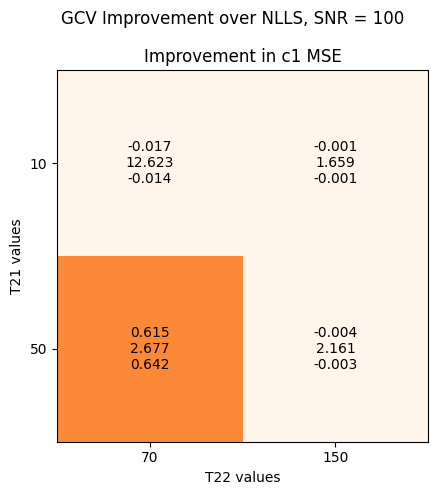

In [47]:
if GCV_opt:
    #Parameter of interest, using the standard indexing for this code
    POI = 0
    fig, ax = plt.subplots(figsize = (5, 5), tight_layout=True)
    fig.suptitle("GCV Improvement over NLLS, SNR = %s" % SNR)
    imc1 = ax.imshow(GCV_imp_array[0,0,:,:,POI], cmap = 'Oranges', vmin = 0, vmax = 1.2)

    ax.set_title('Improvement in c1 MSE')
    ax.set_xticks(np.arange(len(T22_set)))
    ax.set_yticks(np.arange(len(T21_set)))
    ax.set_xticklabels(T22_set)
    ax.set_yticklabels(T21_set)
    ax.set_ylabel('T21 values')
    ax.set_xlabel('T22 values')

    for i in range(len(T21_set)):
        for j in range(len(T22_set)):
            MSE_summary = (f"{round(GCV_imp_array[0,0,i,j,0], 3)}\n{round(GCV_imp_bias_array[0,0,i,j,0], 3)}\n{round(GCV_imp_var_array[0,0,i,j,0], 3)}")
            text = ax.text(j, i, MSE_summary, ha="center", va="center", color="black")

    with h5py.File(f'SimulationSets//GCV//fig2set_{SNR}_' + day + month + year +'.hdf5','a') as f:
        #Save a data set
        # dset = f.create_dataset('runInfo',data=runInfo)
        dset = f.create_dataset('MSE_array',data=GCV_MSE_array)
        dset = f.create_dataset('lambda_array',data=GCV_lambda_array)
        dset = f.create_dataset('improvement_array',data=GCV_imp_array)
        dset = f.create_dataset('bias_improvement_array',data=GCV_imp_bias_array)
        dset = f.create_dataset('variance_improvement_array',data=GCV_imp_var_array)

    f = open(f'SimulationSets//GCV//runInfo_{SNR}_' + day + month + year +'.pkl','wb')
    pickle.dump(runInfo,f)

In [25]:
#POI = 0
# fig, ax = plt.subplots(2, 2, figsize = (10, 10), tight_layout=True)
# fig.suptitle("DNN improvement over NLLS, SNR = %s" % SNR)
# imc1 = ax[0,0].imshow(DNN_imp_array[0,0,:,:,0])
# imc2 = ax[0,1].imshow(DNN_imp_array[0,0,:,:,1])
# imT21 = ax[1,0].imshow(DNN_imp_array[0,0,:,:,2])
# imT22 = ax[1,1].imshow(DNN_imp_array[0,0,:,:,3])

# ax[0,0].set_title('Improvement in c1 MSE')
# ax[0,0].set_xticks(np.arange(len(T22_set)))
# ax[0,0].set_yticks(np.arange(len(T21_set)))
# ax[0,0].set_xticklabels(T22_set)
# ax[0,0].set_yticklabels(T21_set)
# ax[0,0].set_ylabel('T21 values')
# ax[0,0].set_xlabel('T22 values')

# for i in range(len(T21_set)):
#     for j in range(len(T22_set)):
#         text = ax[0,0].text(j, i, round(DNN_imp_array[0,0,i,j,0], 2), ha="center", va="center", color="red")
        
# ax[1,0].set_title('Improvement in c2 MSE')
# ax[1,0].set_xticks(np.arange(len(T22_set)))
# ax[1,0].set_yticks(np.arange(len(T21_set)))
# ax[1,0].set_xticklabels(T22_set)
# ax[1,0].set_yticklabels(T21_set)
# ax[1,0].set_ylabel('T21 values')
# ax[1,0].set_xlabel('T22 values')

# for i in range(len(T21_set)):
#     for j in range(len(T22_set)):
#         text = ax[1,0].text(j, i, round(DNN_imp_array[0,0,i,j,1], 2), ha="center", va="center", color="red")
        
# ax[0,1].set_title('Improvement in T21 MSE')
# ax[0,1].set_xticks(np.arange(len(T22_set)))
# ax[0,1].set_yticks(np.arange(len(T21_set)))
# ax[0,1].set_xticklabels(T22_set)
# ax[0,1].set_yticklabels(T21_set)
# ax[0,1].set_ylabel('T21 values')
# ax[0,1].set_xlabel('T22 values')

# for i in range(len(T21_set)):
#     for j in range(len(T22_set)):
#         text = ax[0,1].text(j, i, round(DNN_imp_array[0,0,i,j,2], 2), ha="center", va="center", color="red")
        
# ax[1,1].set_title('Improvement in T22 MSE')
# ax[1,1].set_xticks(np.arange(len(T22_set)))
# ax[1,1].set_yticks(np.arange(len(T21_set)))
# ax[1,1].set_xticklabels(T22_set)
# ax[1,1].set_yticklabels(T21_set)
# ax[1,1].set_ylabel('T21 values')
# ax[1,1].set_xlabel('T22 values')

# for i in range(len(T21_set)):
#     for j in range(len(T22_set)):
#         text = ax[1,1].text(j, i, round(DNN_imp_array[0,0,i,j,3], 2), ha="center", va="center", color="red")
# plt.show()

##### Exploring the corner cases

In [26]:
if explore_corners:

    c1_set = [0.5]
    c2_set = [0.5]
    T21_set1 = [10]
    T22_set1 = [150]

    T21_set2 = [50]
    T22_set2 = [70]

    n_opt = 25
    n_iters = np.linspace(500//n_opt,500,25)
    iter_length = np.size(n_iters)

    oracle_topRight_MSE = np.zeros((iter_length,4))
    oracle_botLeft_MSE = np.zeros((iter_length,4))
    GCV_topRight_MSE = np.zeros((iter_length,4))
    GCV_botLeft_MSE = np.zeros((iter_length,4))

    for i in trange(iter_length):

        iter_size = n_iters[i]

        oracle_MSE_array, oracle_lambda_array, oracle_imp_array = get_lam_selection_MSE_array(
            c1_set, c2_set, T21_set1, T22_set1, lambdas, 'oracle', aggregate=True, noise_iterations = iter_size)
        oracle_topRight_MSE[i,:] = oracle_MSE_array[0,0,0,0,:]
            
        GCV_MSE_array, GCV_lambda_array, GCV_imp_array = get_lam_selection_MSE_array(
            c1_set, c2_set, T21_set1, T22_set1, lambdas, 'GCV', noise_iterations = iter_size)
        GCV_topRight_MSE[i,:] =  GCV_MSE_array[0,0,0,0,:]

        oracle_MSE_array, oracle_lambda_array, oracle_imp_array = get_lam_selection_MSE_array(
            c1_set, c2_set, T21_set2, T22_set2, lambdas, 'oracle', aggregate=True, noise_iterations = iter_size)
        oracle_botLeft_MSE[i,:] = oracle_MSE_array[0,0,0,0,:]
            
        GCV_MSE_array, GCV_lambda_array, GCV_imp_array = get_lam_selection_MSE_array(
            c1_set, c2_set, T21_set2, T22_set2, lambdas, 'GCV', noise_iterations = iter_size)
        GCV_botLeft_MSE[i,:] =  GCV_MSE_array[0,0,0,0,:]

In [27]:
if explore_corners:
    save_MSE_array = False
    load_MSE_array = False
    n_iters = np.arange(10,501,10)

    if save_MSE_array:
        try:
            with h5py.File('Storage//CornerCases.hdf5','a') as f:
                #Save a data set
                dset = f.create_dataset('oracle_topRight',data=oracle_topRight_MSE)
                dset = f.create_dataset('oracle_botLeft',data=oracle_botLeft_MSE)
                dset = f.create_dataset('GCV_topRight',data=GCV_topRight_MSE)
                dset = f.create_dataset('GCV_botLeft',data=GCV_botLeft_MSE)
        except:
            print("Error")

    if load_MSE_array:
        with h5py.File('Storage//CornerCases.hdf5','a') as f:
            oracle_topRight_MSE = np.array(f['oracle_topRight'])
            oracle_botLeft_MSE = np.array(f['oracle_botLeft'])
            GCV_topRight_MSE = np.array(f['GCV_topRight'])
            GCV_botLeft_MSE = np.array(f['GCV_botLeft'])

In [28]:
if explore_corners:
    fig, ax = plt.subplots(1,2,figsize=(10,5), tight_layout=True)
    fig.suptitle('MSE Compared to Iteration')
    ax[0].plot(n_iters, oracle_topRight_MSE[:,0], label= 'Oracle TopRight', alpha = 0.7)
    ax[0].plot(n_iters, GCV_topRight_MSE[:,0], label= 'GCV TopRight', alpha = 0.7)
    ax[1].plot(n_iters, oracle_botLeft_MSE[:,0], label= 'Oracle BotLeft', alpha = 0.7)
    ax[1].plot(n_iters, GCV_botLeft_MSE[:,0], label= 'GCV BotLeft', alpha = 0.7)
    ax[0].set_xlabel('Number of Iterations')
    ax[0].set_ylabel('MSE')
    ax[0].set_title('T21 = 10 & T22 = 150')
    ax[1].set_xlabel('Number of Iterations')
    ax[1].set_ylabel('MSE')
    ax[1].set_title('T21 = 50 & T22 = 70')
    ax[0].legend()
    ax[1].legend()
    plt.show()

# Use a numerical method to calculate the biased CRLB

In [29]:
def construct_P_theta_n(theta_n, c_range, T2_range, M):
    #theta_n are the 4 parameters to perturb around, given as a numpy array
    #c_range and T2_range are define the range of the perturbations about ci and T2i
    #M is the number of total perturbations
    #The first entry in P_theta_n is always just theta_n
    P_theta_n = np.zeros((4, M+1))
    P_theta_n[:,0] = theta_n
    for m in range(M):
        a1_m = np.random.uniform(low=c_range[0],high=c_range[1])
        a2_m = np.random.uniform(low=c_range[0],high=c_range[1])
        tau1_m = np.random.uniform(low=T2_range[0],high=T2_range[1])
        tau2_m = np.random.uniform(low=T2_range[0],high=T2_range[1])
        
        T_theta_nm = np.append(a1_m, [a2_m, tau1_m, tau2_m])
        
        P_theta_n[:, m+1] = theta_n + T_theta_nm
        
    return P_theta_n

def construct_A_n(P_theta_n):
    #Gives matrix A_n for least squares minimization to get biased CRLB for parameters theta_n
    #P_theta_n is the perturbation matrix about some theta_n
    M = P_theta_n.shape[1]-1
    theta_n = P_theta_n[:,0]
    
    #Get first four rows of A_n first
    z = P_theta_n[:,1] - theta_n
    B1 = [z[0],0,0,0,z[1],0,0,0,z[2],0,0,0,z[3],0,0,0]
    B2 = [0,z[0],0,0,0,z[1],0,0,0,z[2],0,0,0,z[3],0,0]
    B3 = [0,0,z[0],0,0,0,z[1],0,0,0,z[2],0,0,0,z[3],0]
    B4 = [0,0,0,z[0],0,0,0,z[1],0,0,0,z[2],0,0,0,z[3]]
    A_n = np.stack((B1, B2, B3, B4),axis=0)
    #Then get the rest of the rows
    for m in range(M-1):
        z = P_theta_n[:,m+2] - theta_n
        B1 = [z[0],0,0,0,z[1],0,0,0,z[2],0,0,0,z[3],0,0,0]
        B2 = [0,z[0],0,0,0,z[1],0,0,0,z[2],0,0,0,z[3],0,0]
        B3 = [0,0,z[0],0,0,0,z[1],0,0,0,z[2],0,0,0,z[3],0]
        B4 = [0,0,0,z[0],0,0,0,z[1],0,0,0,z[2],0,0,0,z[3]]
        
        B_mn = np.stack((B1, B2, B3, B4), axis=0)
        A_n = np.concatenate((A_n, B_mn),axis=0)
        
    return A_n

def run_NR_P_theta_n(P_theta_n, n_noise_realizations):
    M = P_theta_n.shape[1]
    estimates = np.zeros((4, M, n_noise_realizations))
    for m in range(M):
        [c1, c2, T21, T22] = P_theta_n[:,m]
        
        #np.random.seed(m)
        noiseless_curve = G(tdata, c1, c2, T21, T22)
        for i in range(n_noise_realizations):
            noise_realization = add_noise(noiseless_curve, SNR)
            est = estimate_parameters(noise_realization, 0)
            estimates[:,m,i] = est
    return estimates

def x_cost_fun(bias_var_n, A_n):
    def function(x):
        #For giving least squares the vector of the residual
        return (bias_var_n - A_n@x)
    return function

def biased_CRLB(theta_n, c_range, T2_range, M, n_noise_realizations):
    #Calculates the biased CRLB about a set of parameters theta_n
    P_theta_n = construct_P_theta_n(theta_n, c_range, T2_range, M)
    estimates = run_NR_P_theta_n(P_theta_n, n_noise_realizations)
    
    sample_mean = np.mean(estimates,axis=-1)
    Q_0 = sample_mean[:,0]
    sample_mean_shortened = sample_mean[:,1:]
    
    bias_var_n = np.reshape((sample_mean_shortened.transpose() - Q_0),-1)
    
    A_n = construct_A_n(P_theta_n)
    
    minimization = x_cost_fun(bias_var_n, A_n)
    x_hat_n = least_squares(minimization, np.zeros(16))['x']
    
    #x_hat_n = (np.linalg.inv(A_n.transpose()@A_n)@A_n.transpose())@bias_var_n
    S_hat_n = np.transpose(np.reshape(x_hat_n, (4,4)))
    CRLB_n = cov_matrix(theta_n[0],theta_n[1],theta_n[2],theta_n[3], SNR)

    biased_CRLB = S_hat_n@CRLB_n@S_hat_n.transpose()
    
    return biased_CRLB, S_hat_n

def check_CRLB_convergence(n_set, theta_n, c_range, T2_range, M, verbose=False):
    n_checks = len(n_set)
    P_theta_n = construct_P_theta_n(theta_n, c_range, T2_range, M)
    CRLB_n = cov_matrix(theta_n[0],theta_n[1],theta_n[2],theta_n[3], SNR)
    biased_CRLB_set = []
    c1_CRLB_set = []
    c2_CRLB_set = []
    T21_CRLB_set = []
    T22_CRLB_set = []
    sensitivity_set = []
    for i in trange(n_checks):
        if i == 0:
            n_noise_realizations = n_set[i]
            estimates = run_NR_P_theta_n(P_theta_n, n_noise_realizations)
        else:
            n_noise_realizations = n_set[i] - n_set[i-1]
            new_estimates = run_NR_P_theta_n(P_theta_n, n_noise_realizations)
            estimates = np.append(estimates, new_estimates,axis=-1)
        sample_mean = np.mean(estimates, axis=-1)
        Q_0 = sample_mean[:,0]
        sample_mean_shortened = sample_mean[:,1:]
        bias_var_n = np.reshape((sample_mean_shortened.transpose() - Q_0),-1)
        A_n = construct_A_n(P_theta_n)
        
        minimization = x_cost_fun(bias_var_n, A_n)
        x_hat_n = least_squares(minimization, np.zeros(16))['x']
        S_hat_n = np.transpose(np.reshape(x_hat_n, (4,4)))
        sensitivity_set.append(S_hat_n)

        biased_CRLB = S_hat_n@CRLB_n@(S_hat_n.transpose())
        biased_CRLB_set.append(biased_CRLB)
        
        c1_CRLB = biased_CRLB[0,0]
        c1_CRLB_set.append(c1_CRLB)
        c2_CRLB = biased_CRLB[1,1]
        c2_CRLB_set.append(c2_CRLB)
        T21_CRLB = biased_CRLB[2,2]
        T21_CRLB_set.append(T21_CRLB)
        T22_CRLB = biased_CRLB[3,3] 
        T22_CRLB_set.append(T22_CRLB)
        if verbose:
            print('Biased CRLB at %s noise realizations:'%(n_set[i]), c1_CRLB, c2_CRLB, T21_CRLB, T22_CRLB)
            
    return biased_CRLB_set, c1_CRLB_set, c2_CRLB_set, T21_CRLB_set, T22_CRLB_set, sensitivity_set

In [30]:
theta_n = np.array((0.3, 0.7, 50, 90))
c_range = [-0.05, 0.05]
T2_range = [-2.5, 2.5]
M = 10
n_noise_realizations = 100

CRLB_n = cov_matrix(theta_n[0],theta_n[1],theta_n[2],theta_n[3], SNR)
biased_CRLB_n, sensitivity = biased_CRLB(theta_n, c_range, T2_range, M, n_noise_realizations)

In [31]:
#Check for convergence
theta_n = np.array((0.5, 0.5, 20, 200))
c_range = [-0.05, 0.05]
T2_range = [-2.5, 2.5]
M = 10
n_set = np.linspace(100, 100000, 1000, dtype=int)
biased_CRLB_set, c1_CRLB_set, c2_CRLB_set, T21_CRLB_set, T22_CRLB_set, sensitivity_set = check_CRLB_convergence(
    n_set, theta_n, c_range, T2_range, M, verbose=False)

  1%|          | 11/1000 [21:36<32:23:17, 117.89s/it]


KeyboardInterrupt: 

In [ ]:
CRLB_n = cov_matrix(theta_n[0],theta_n[1],theta_n[2],theta_n[3], SNR)
c1_CRLB = CRLB_n[0,0]
c2_CRLB = CRLB_n[1,1]
T21_CRLB = CRLB_n[2,2]
T22_CRLB = CRLB_n[3,3]
fig, ax = plt.subplots(1,4,figsize=(18,4),tight_layout=True)
fig.suptitle('Convergence of biased CRLB at SNR %s'%SNR)
ax[0].plot(n_set, c1_CRLB_set, label='c1 biased CRLB')
ax[0].axhline(y=c1_CRLB, label = 'c1 CRLB', color='r')
ax[0].set_xlabel('Noise realizations')
ax[0].set_ylabel('CRLB')
ax[0].set_title('c1 convergence')
ax[0].legend()
ax[1].plot(n_set, c2_CRLB_set, label='c2 biased CRLB')
ax[1].axhline(y=c2_CRLB, label = 'c2 CRLB', color='r')
ax[1].set_xlabel('Noise realizations')
ax[1].set_ylabel('CRLB')
ax[1].set_title('c2 convergence')
ax[1].legend()
ax[2].plot(n_set, T21_CRLB_set, label='T21 biased CRLB')
ax[2].axhline(y=T21_CRLB, label = 'T21 CRLB', color='r')
ax[2].set_xlabel('Noise realizations')
ax[2].set_ylabel('CRLB')
ax[2].set_title('T21 convergence')
ax[2].legend()
ax[3].plot(n_set, T22_CRLB_set, label='T22 biased CRLB')
ax[3].axhline(y=T22_CRLB, label = 'T22 CRLB', color='r')
ax[3].set_xlabel('Noise realizations')
ax[3].set_ylabel('CRLB')
ax[3].set_title('T22 convergence')
ax[3].legend()

plt.show()

In [ ]:
# with h5py.File('Brain MWF Maps//Biased CRLB SNR 1 Convergence, 1e5 NR 5-22.hdf5','a') as f2:
#     f2.create_dataset('biased CRLB', data=biased_CRLB_set)
#     f2.create_dataset('sensitivity', data=sensitivity_set)